Connected to Python 3.10.11

### Load libraries

In [1]:
import sys
import os
import matplotlib.pyplot as plt
import pandas as pd

# Directly import helper function
notebook_dir = os.getcwd()
src_path = os.path.abspath(os.path.join(notebook_dir, '..', 'src'))
if src_path not in sys.path:
    sys.path.append(src_path)

from utils import add_src_to_path
add_src_to_path()

from data_split import split_time_series_by_river
from rf_model import train_and_apply_rf_with_tuning
from plot_predictions import plot_predictions_by_river
from plot_predictions import plot_actual_vs_predicted

### Select River system and load dataset

In [2]:
# Choose from "Bristol Bay", "Fraser River" and "Columbia River"
river_system = "Fraser River"

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))  # assumes notebook is in /notebooks
data_path = os.path.join(project_root, 'data', 'Combined_FeatureSet_For_Model.csv')

combined_df = pd.read_csv(data_path)
combined_df = combined_df[combined_df["System"] == river_system]
combined_df = combined_df[combined_df["River"] == "Late Stuart"]


### Split data

In [3]:
train_df, test_df = split_time_series_by_river(
    combined_df,
    time_column="Year",
    group_columns=["System", "River"],
    test_fraction=0.2,
    gap_years=0  # Set to 1 if you want a 1-year gap between train and test
)

print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")

Train shape: (58, 40)
Test shape: (15, 40)


### One-hot encode the 'River' column

In [4]:
train_df["River_Name"] = train_df["River"] # For visualization
test_df["River_Name"] = test_df["River"]

train_df_encoded = pd.get_dummies(train_df, columns=["River"], prefix="River")
test_df_encoded = pd.get_dummies(test_df, columns=["River"], prefix="River")

### Train random forest with gridsearch hyperparameter tuning

In [5]:
results = train_and_apply_rf_with_tuning(train_df_encoded, test_df_encoded)

Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Random Forest R2: -6.69
Random Forest MSE: 141899571301.49
Random Forest MAPE: 883.00


In [6]:
results["Metrics_by_System"]

,System,R2,MSE,MAPE
0,Fraser River,-6.69052,1.418996e+11,882.999482


In [7]:
results["Metrics_by_River"]

,River_Name,R2,MSE,MAPE
0,Late Stuart,-6.69052,1.418996e+11,882.999482


### Plot predictions

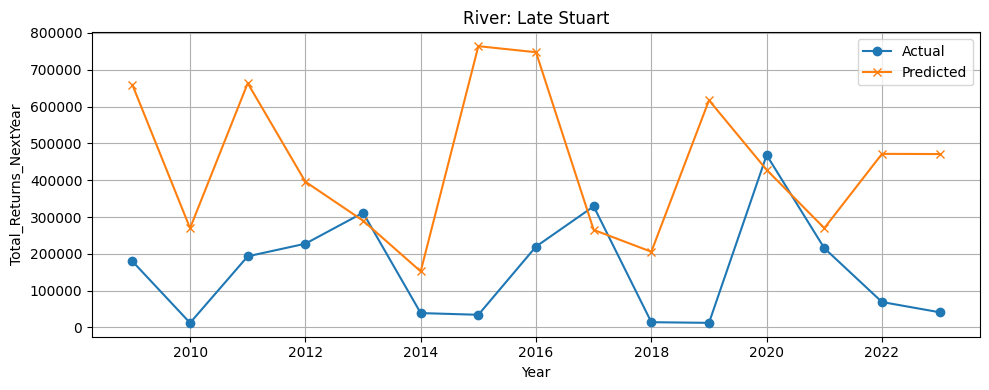

In [8]:
plot_predictions_by_river(results["Timeline"])

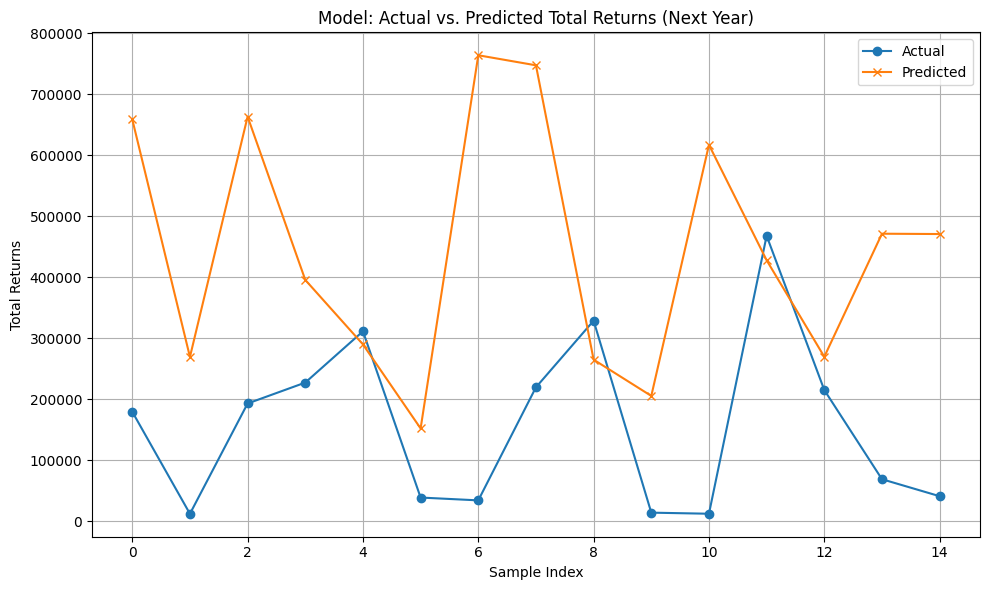

In [9]:
# Plot Predicted vs Actual
plot_actual_vs_predicted(results)

### Feature Importances

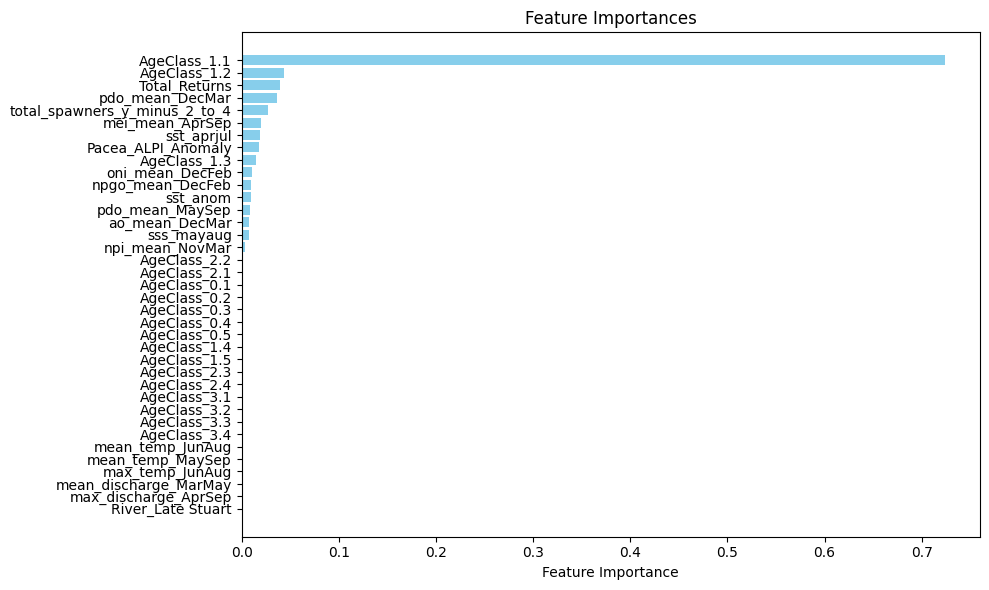

In [10]:
sorted_items = sorted(results["Feature_Importances"].items(), key=lambda x: x[1], reverse=True)
features, importances = zip(*sorted_items)

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(features, importances, color='skyblue')
plt.xlabel('Feature Importance')
plt.title('Feature Importances')
plt.gca().invert_yaxis()  # Most important on top
plt.tight_layout()
plt.show()